In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import pandas as pd
from tqdm import tqdm

In [15]:
#All in arbitrary units. Can add actual units later
radius = 1.5
height = 8.0
num_particles = 100000
mass = 0.05
max_velocity = 1.0

total_mass = num_particles * mass

print(total_mass)

5000.0


In [16]:
def generate_particles(radius, height, num_particles):
    r = np.random.normal(0, 2, num_particles)
    theta = np.random.uniform(0, 2 * np.pi, num_particles)
    z = np.random.uniform(-height / 2, height / 2, num_particles)

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Generate random data from a Gaussian distribution
    #mean = [0, 0]
    #cov = [[1, 0], [0, 1]]  # Identity matrix for uncorrelated variables
    #x, y = np.random.multivariate_normal(mean, cov, num_particles).T

    vx = np.random.uniform(-max_velocity, max_velocity, num_particles)
    vy = np.random.uniform(-max_velocity, max_velocity, num_particles)
    vz = np.random.uniform(-max_velocity, max_velocity, num_particles)

    return x, y, z, vx, vy, vz

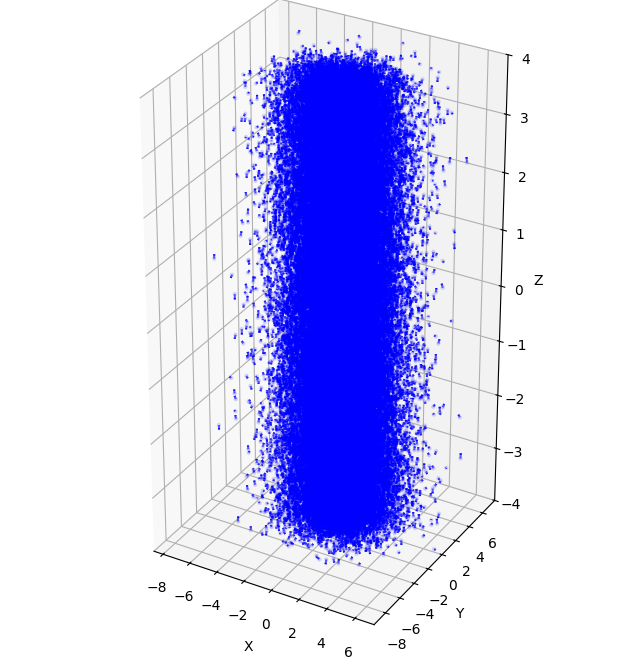

In [17]:
x, y, z, vx, vy, vz = generate_particles(radius, height, num_particles)


fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z, c = 'b', marker = 'o', s = 5, alpha = 0.1)
ax.quiver(x, y, z, vx, vy, vz, length = 0.1, normalize = True, color = 'b', alpha = 0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([np.min(y), np.max(y)])
ax.set_zlim([-height/2, height/2])
ax.set_box_aspect([1, 1, 2])

plt.show()

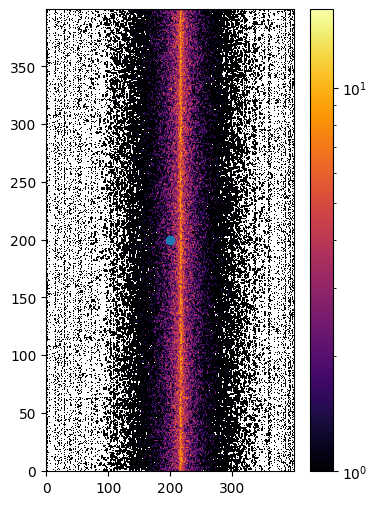

In [18]:
num_bins = 400

hist_xz, xedges, zedges = np.histogram2d(x, z, bins = num_bins, range = [[np.min(x), np.max(x)], [np.min(z), np.max(z)]])
#hist_xy, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[-radius, radius], [-radius, radius]])

spine_particles = hist_xz.T

fig, ax = plt.subplots(figsize = (4, 6))
scatter = ax.imshow(spine_particles, cmap='inferno', #extent = [np.min(x), np.max(x), -height/2, height/2], 
                    origin = 'lower', 
                    norm=colors.LogNorm(), aspect = 'auto')
pixel_x = [200]
pixel_y = [200]

plt.scatter(pixel_x, pixel_y)

# Add a colorbar
plt.colorbar(scatter)

In [19]:
x_pix = []
for i in x:
    diff = xedges - i
    x_pix.append(list(np.abs(diff)).index(np.min(np.abs(diff))))

z_pix = []
for i in z:
    diff = zedges - i
    z_pix.append(list(np.abs(diff)).index(np.min(np.abs(diff))))

print(x_pix[0], z_pix[0], vy[0])

df = pd.DataFrame(data = {'X Pixels' : x_pix, 
                         'Z Pixels' : z_pix,
                         'LoS Velocity' : vy})

df_sorted = df.sort_values(by=['X Pixels', 'Z Pixels'])
df_sorted = df_sorted.reset_index(drop=True)

#display(df_sorted)

x_pix_sorted = np.array(df_sorted['X Pixels'])
z_pix_sorted = np.array(df_sorted['Z Pixels'])
vel_sorted = np.array(df_sorted['LoS Velocity'])

x_z_value = []
for i in tqdm(range(len(x_pix_sorted))):
    if x_pix_sorted[i] in range(num_bins):
        if [x_pix_sorted[i], z_pix_sorted[i]] not in x_z_value:
            x_z_value.append([float(x_pix_sorted[i]), float(z_pix_sorted[i])])
    else:
        continue

228 145 -0.7568165471236648


100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [22:47<00:00, 73.11it/s]


In [ ]:
velocity_lists = []
for i in tqdm(range(len(x_z_value))):
    pixel_x = x_z_value[i][0]
    pixel_z = x_z_value[i][1]
    appending_vel = []
    for j in range(len(z_pix_sorted)):
        if pixel_x == x_pix_sorted[j] and pixel_z == z_pix_sorted[j]:
            appending_vel.append(vel_sorted[j])
        else:
            continue
    velocity_lists.append(appending_vel)

 38%|█████████████████████████████▏                                               | 16904/44632 [19:12<31:30, 14.67it/s]

In [299]:
mean_velocity = [np.mean(velocity_lists[i]) for i in range(len(velocity_lists))]

mean_vel_map = []
for row in tqdm(range(num_bins)):
    row_append = []
    for column in range(num_bins):
        if [column, row] in x_z_value:
            row_append.append(mean_velocity[list(x_z_value).index([column, row])])
        else:
            row_append.append(np.nan)
    mean_vel_map.append(row_append)

100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 29.02it/s]


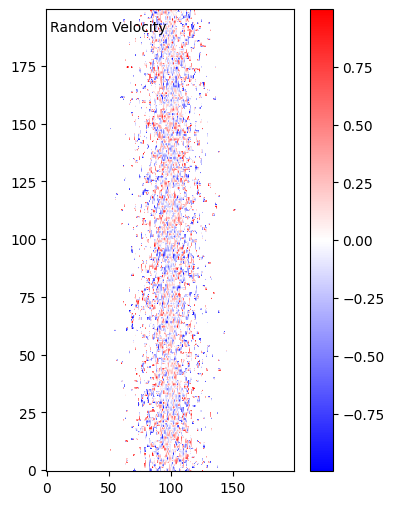

In [298]:
plt.figure(figsize = (4, 6))
velocity = plt.imshow(mean_vel_map, origin = 'lower', cmap = 'bwr', aspect = 'auto')
plt.text(3, 190, 'Random Velocity')
plt.colorbar(velocity)

200 200


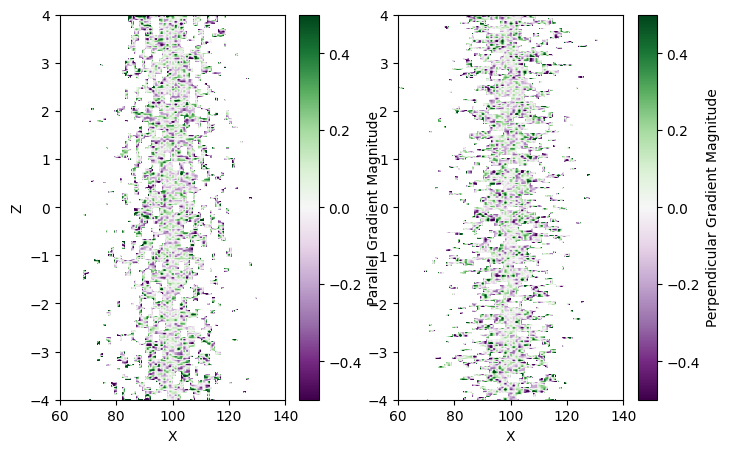

In [318]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

grad_y_vel, grad_x_vel = divergence(mean_vel_map)

plt.figure(figsize = (8, 5))
ax_1 = plt.subplot(121)
im = ax_1.imshow(grad_y_vel, cmap = 'PRGn', extent = [np.min(x), np.max(x), -height/2, height/2], origin = 'lower', aspect = 'auto',
                vmin = -0.5, vmax = 0.5)
ax_1.set_xlim(60, 140)
plt.xlabel('X')
plt.ylabel('Z')
cbar = plt.colorbar(im, label = 'Parallel Gradient Magnitude')

ax_2 = plt.subplot(122)
im = ax_2.imshow(grad_x_vel, cmap = 'PRGn', extent = [np.min(x), np.max(x), -height/2, height/2], origin = 'lower', aspect = 'auto',
                vmin = -0.5, vmax = 0.5)
ax_2.set_xlim(60, 140)
plt.xlabel('X')
#plt.ylabel('Z')
cbar = plt.colorbar(im, label = 'Perpendicular Gradient Magnitude')

100%|██████████████████████████████████████| 200/200 [00:00<00:00, 13488.68it/s]

200 200



/tmp/ipykernel_3220607/626933259.py:17: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (-grad_x_dist[i][j] * grad_x_vel[i][j])/((grad_x_dist[i][j])**2 + (grad_y_dist[i][j])**2)
/tmp/ipykernel_3220607/626933259.py:29: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (-grad_x_dist[i][j] * grad_y_vel[i][j])/((grad_x_dist[i][j])**2 + (grad_y_dist[i][j])**2)


(60.0, 140.0)

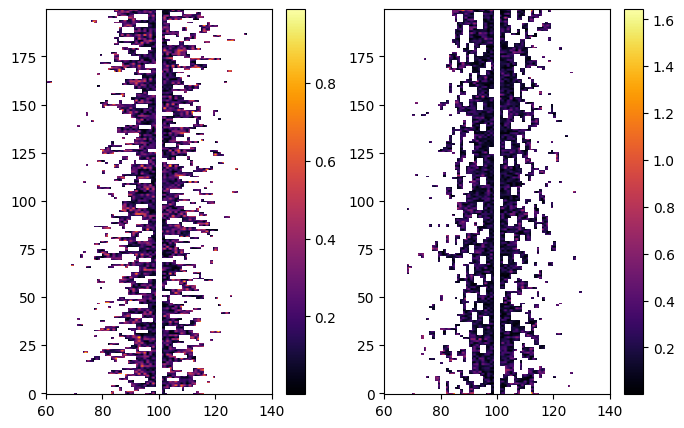

In [350]:
distance_transform = []
for row in tqdm(range(200)):
    row_append = []
    for column in range(200):
        row_append.append(np.abs(column - 100))
    distance_transform.append(row_append)

#plt.imshow(distance_transform, origin = 'lower')
#plt.xlim(60, 140)

grad_y_dist, grad_x_dist = divergence(distance_transform)

perp_divergence = []
for i in range(200):
    summed = []
    for j in range(200):
        proj_length = (-grad_x_dist[i][j] * grad_x_vel[i][j])/((grad_x_dist[i][j])**2 + (grad_y_dist[i][j])**2)
        #print(proj_length)
        magnitude = np.sqrt((-grad_x_dist[i][j] * proj_length)**2 + (-grad_y_dist[i][j] * proj_length)**2)
        
        summed.append(magnitude)
        
    perp_divergence.append(summed)

para_divergence = []
for i in range(200):
    summed = []
    for j in range(200):
        proj_length = (-grad_x_dist[i][j] * grad_y_vel[i][j])/((grad_x_dist[i][j])**2 + (grad_y_dist[i][j])**2)
        #print(proj_length)
        magnitude = np.sqrt((-grad_x_dist[i][j] * proj_length)**2 + (-grad_y_dist[i][j] * proj_length)**2)
        
        summed.append(magnitude)
        
    para_divergence.append(summed)

plt.figure(figsize = (8, 5))
ax_1 = plt.subplot(121)
div = ax_1.imshow(perp_divergence, origin = 'lower', cmap = 'inferno', aspect = 'auto')
plt.colorbar(div)
ax_1.set_xlim(60, 140)

ax_2 = plt.subplot(122)
div = ax_2.imshow(para_divergence, origin = 'lower', cmap = 'inferno', aspect = 'auto')
plt.colorbar(div)
ax_2.set_xlim(60, 140)

Text(0, 0.5, 'Fraction of Pixels')

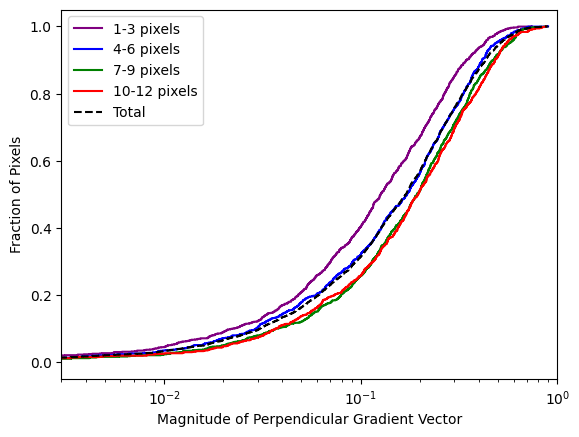

In [349]:
import math

vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(200):
    for j in range(200):
        if 1 <= distance_transform[j][i] <= 3:
            #dist_spine_8.append(subregion_spines[j][i])
            vec_mag_low.append(perp_divergence[j][i])
            total_vec_mag.append(perp_divergence[j][i])
        elif 4 <= distance_transform[j][i] <= 6:
            #dist_spine_7.append(subregion_spines[j][i])
            vec_mag_med.append(perp_divergence[j][i])
            total_vec_mag.append(perp_divergence[j][i])
        elif 7 <= distance_transform[j][i] <= 9:
            #dist_spine_6.append(subregion_spines[j][i])
            vec_mag_high.append(perp_divergence[j][i])
            total_vec_mag.append(perp_divergence[j][i])
        elif 10 <= distance_transform[j][i] <= 12:
            #dist_spine_5.append(subregion_spines[j][i])
            vec_mag_higher.append(perp_divergence[j][i])
            total_vec_mag.append(perp_divergence[j][i])

vec_mag_low = [x for x in vec_mag_low if (math.isnan(x) == False)]
vec_mag_med = [x for x in vec_mag_med if (math.isnan(x) == False)]
vec_mag_high = [x for x in vec_mag_high if (math.isnan(x) == False)]
vec_mag_higher = [x for x in vec_mag_higher if (math.isnan(x) == False)]
total_vec_mag = [x for x in total_vec_mag if (math.isnan(x) == False)]

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

plt.xscale('log')
plt.xlim(0.003, 1)
plt.ylim(-0.05, 1.05)
#plt.text(0.1, 0.4, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'upper left')
plt.xlabel('Magnitude of Perpendicular Gradient Vector')
plt.ylabel('Fraction of Pixels')